In [65]:
TRAIN_PATH="data/train"
TEST_PATH="data/test"

IMAGE_SIZE_PX=200
GENERATOR_BATCH_SIZE=500
RESCALE=1./255

TRAINING_BATCH_SIZE=32
TRAINING_EPOCH=1 # Change this as needed

In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=RESCALE).flow_from_directory(TRAIN_PATH, target_size=(IMAGE_SIZE_PX, IMAGE_SIZE_PX), batch_size=GENERATOR_BATCH_SIZE)
test_generator = ImageDataGenerator(rescale=RESCALE).flow_from_directory(TEST_PATH, target_size=(IMAGE_SIZE_PX, IMAGE_SIZE_PX), batch_size = GENERATOR_BATCH_SIZE)

Found 498 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [3]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

In [4]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)

In [5]:
datagen = ImageDataGenerator(
        rotation_range=30,
        horizontal_flip=True,
        fill_mode='nearest')

In [6]:
datagen.fit(train_images, augment=True)

In [11]:
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from keras import backend as keras_backend

base_model = VGG16(include_top=False, input_shape = (IMAGE_SIZE_PX, IMAGE_SIZE_PX, 3), weights = 'imagenet')
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 14,715,714
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["accuracy"])

In [13]:
keras_backend.set_value(model.optimizer.learning_rate, 0.0015)

In [18]:
# Training

results = model.fit(datagen.flow(train_images, train_labels, batch_size=TRAINING_BATCH_SIZE), epochs = TRAINING_EPOCH, validation_data =(val_images, val_labels), steps_per_epoch=len(train_images) / TRAINING_BATCH_SIZE)


11/11 [==============================] - 142s 12s/step - loss: 0.7206 - accuracy: 0.4987 - val_loss: 0.6721 - val_accuracy: 0.6400


In [19]:
results_train = model.evaluate(train_images, train_labels)

12/12 [==============================] - 37s 3s/step - loss: 0.6833 - accuracy: 0.5603


In [20]:
results_test = model.evaluate(test_images, test_labels)

16/16 [==============================] - 41s 3s/step - loss: 0.6934 - accuracy: 0.5060


In [63]:
import os
import numpy as np
from PIL import Image
from skimage.io import imread
import matplotlib.pyplot as plt

def download_and_predict(url, filename):
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img.save(filename)
    img = img.convert('RGB')
    plt.imshow(img)
    plt.axis('off')

    img = img.resize((IMAGE_SIZE_PX, IMAGE_SIZE_PX))
        
    img = imread(filename)
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    pred = probs.argsort()[0][::-1][0]
    
    if pred == 1.:
        print("Hotdog")
    else:
        print("Not hotdog")

Hotdog


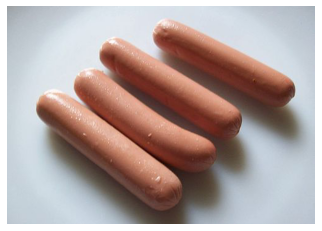

In [32]:
SAMPLE_HOTDOG_IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/59/Germanvegetariansausage.jpg/500px-Germanvegetariansausage.jpg"
HOTDOG_FILENAME = "hotdog.jpg"

download_and_predict(url=SAMPLE_HOTDOG_IMAGE_URL, filename=HOTDOG_FILENAME)

Not hotdog


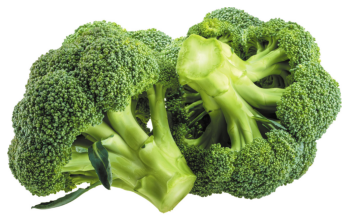

In [64]:
SAMPLE_NOT_HOTDOG_IMAGE_URL = "https://domf5oio6qrcr.cloudfront.net/medialibrary/5390/h1218g16207258089583.jpg"
NOT_HOTDOG_FILENAME = "not_hotdog.jpg"

download_and_predict(url=SAMPLE_NOT_HOTDOG_IMAGE_URL, filename=NOT_HOTDOG_FILENAME)

In [39]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


In [40]:
from tensorflow import keras

model = keras.models.load_model("model")